In [4]:
import numpy as np
import torch
import torch.nn as nn

class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim
        self.gridsize_param = nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32)) #adjusted during training
        self.fouriercoeffs = nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        nn.init.xavier_uniform_(self.fouriercoeffs)
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))
            nn.init.kaiming_normal_(self.bias)
        nn.BatchNorm1d(inputdim)

    def forward(self, x): #Combines cosine/sine terms with learnable coefficents for Fourier expansion and sums them + bias
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        outshape = x.shape[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class Block(nn.Module):
    expansion: int = 2
    def __init__(self, input, output, identity_downsample=None, stride=(1,1)):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input, output, kernel_size=(3,3), stride=(1,1), padding=1)
        self.bn1 = nn.BatchNorm2d(output)
        self.conv2 = nn.Conv2d(output, output*self.expansion, 
                               kernel_size=(3,3), stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(output*self.expansion,)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x = x + identity
        x = self.relu(x)
        return x
    
class ResNet_KAN(nn.Module):
    def __init__(self, block: Block, layers, input_shape, output_shape):
        super(ResNet_KAN, self).__init__()
        self.input = 16
        self.conv1 = nn.Conv2d(input_shape, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(1,1))

        ###ResNet Layers
        self.layer1 = self.make_layer(block,layers[0], output=16, stride=(2,2))
        self.layer2 = self.make_layer(block,layers[1], output=32, stride=(2,2))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.KANClassifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(32*block.expansion, 128), 
            nn.ReLU(),
            NaiveFourierKANLayer(128, 128, initial_gridsize=20),
            nn.Linear(128, output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)

        x = self.KANClassifier(x)
        return x
    
    def make_layer(self, block, num_residual_MyBlocks, output, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.input != output*block.expansion:
            identity_downsample = nn.Sequential(nn.Conv2d(
                self.input, output * block.expansion, kernel_size=(1,1), stride=stride),
                nn.BatchNorm2d(output*block.expansion)
            )
        layers.append(block(self.input, output, identity_downsample, stride))
        self.input = output*block.expansion

        for _ in range(num_residual_MyBlocks-1):
            layers.append(block(self.input, output))
        
        return nn.Sequential(*layers)



torch.manual_seed(23)
fsl_model = ResNet_KAN(Block, [2,2,2], input_shape=1, 
                       output_shape=10)
print(f"{fsl_model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in fsl_model.parameters())
print(f"Total number of parameters: {total_params}")


ResNet_KAN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), pa

In [19]:
#Setup device agnostic code
import os
print(f"GPU Avalaibility: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  device = "cuda"
  import torch.backends.cudnn as cudnn
  #Ensure deterministic behaviour if running in GPU
  '''
  Reproducibility: These settings are particularly useful when you need to ensure that results are
  reproducible across different runs, which is important for debugging and verifying that changes in
  your code or model have the desired effect
  '''
  cudnn.deterministic = True
  cudnn.benchmark = False
  !nvidia-smi
else:
   device = "cpu"
   print(f"Number of cores: {os.cpu_count()}")
print(f"Device: {device}")

GPU Avalaibility: True
Fri Feb 21 11:10:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P3              8W /   30W |     505MiB /   4096MiB |     39%      Default |
|                                         |                        |                  N/A |
+------------------------

In [97]:
tensor1 = torch.randn(size=(1, 28, 28))  # Single image (C, H, W)
print(tensor1.shape)  # Should print torch.Size([3, 128, 128])

output = fsl_model(tensor1.unsqueeze(dim=0))  # Add batch dimension
print(output)

device = "cpu"

torch.Size([1, 28, 28])
tensor([[ 0.3850,  0.3722, -0.5950,  0.2429,  1.1070,  1.2100,  0.9900, -0.3724,
         -1.0983,  0.4132]], grad_fn=<ViewBackward0>)


In [98]:
#Functionizing training and testing loops Part 1

def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) #from logits -> prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test Accuracy {test_acc:5f}%")
    return test_loss, test_acc

In [99]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 📌 1️⃣ Load MNIST Dataset (Grayscale 1-Channel Images)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [100]:
loss_fn = nn.CrossEntropyLoss()
num_of_epochs = 10
num_loss_steps = 1
seed_number = 42
learning_rate = 0.001


from tqdm.auto import tqdm


#Define Accuracy Metric
def calculate_accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

In [101]:
import time
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

model_Adam = ResNet_KAN(Block, [2,2,2], input_shape=1, output_shape=len(train_data.classes))
model_Adam
optimizer_Adam= torch.optim.Adam(params=model_Adam.parameters(), 
                                 lr=learning_rate, 
                                 betas=(0.9, 0.99), 
                                 weight_decay=1e-3)

results3 = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_epoch = 0
epoch = num_of_epochs
loss_steps = num_loss_steps 
start_adam = time.perf_counter()
for epoch in tqdm(range(start_epoch, num_of_epochs)):
  if epoch % loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss3, train_accu3 = train(data_loader = train_dataloader,
                                    model = model_Adam,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer_Adam,
                                    calculate_accuracy = calculate_accuracy,
                                    device = device,
                                    loss_steps = loss_steps,
                                    seed = seed);

  test_loss3, test_accu3 = test(data_loader = test_dataloader,
                                     model = model_Adam,
                                     loss_fn = loss_fn,
                                     calculate_accuracy = calculate_accuracy,
                                     device = device,
                                     loss_steps = loss_steps,
                                     seed=seed)

  results3["train_loss"].append(train_loss3)
  results3["train_accu"].append(train_accu3)
  results3["test_loss"].append(test_loss3)
  results3["test_accu"].append(test_accu3)
end_adam = time.perf_counter()
total_time_adam = end_adam - start_adam
print(f"Total Runtime: {total_time_adam}")



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 0.32673 | Training Accuracy: 91.0448%
Test Loss 0.18356 | Test Accuracy 95.252787%
Epoch: 1 
Training Loss: 0.15691 | Training Accuracy: 96.0754%
Test Loss 0.19848 | Test Accuracy 94.247611%
Epoch: 2 


KeyboardInterrupt: 

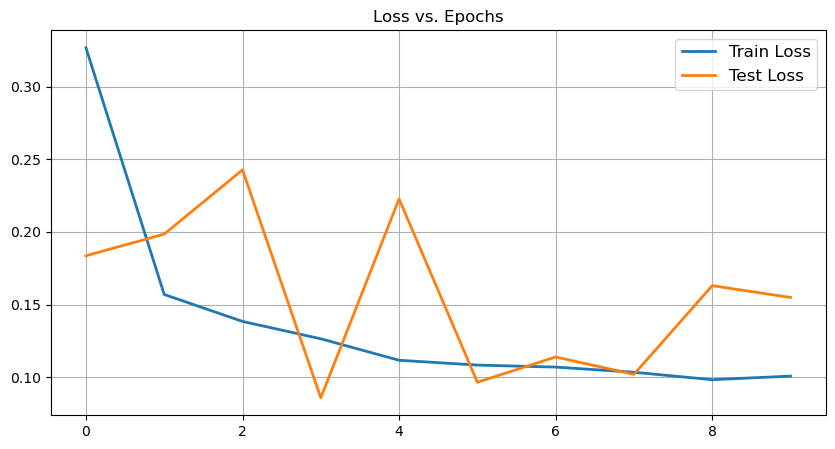

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(results3["train_loss"], linewidth = 2.0, label="Train Loss")
plt.plot(results3["test_loss"], linewidth = 2.0, label="Test Loss")
plt.legend(fontsize=12)
plt.title("Loss vs. Epochs")
plt.grid(True)
plt.show()